In [19]:
using Plots, DataFrames, StatsPlots 
using Random, LinearAlgebra, Statistics, CSV

In [20]:
# load data
crime = CSV.read("crime.csv"; copycols=true);

In [21]:
# clean data
crime[crime.County .== "St Lawrence", :County] = "St. Lawrence"
reports_by_county = sort(by(crime, :County, N_reports = :County => length), :N_reports)  
reporting_counties = reports_by_county.County[reports_by_county.N_reports .== 26]
row_is_reporting_county = [c in reporting_counties for c in crime.County]
crime = crime[row_is_reporting_county, :]

,County,Year,Population,Index_Count,Index_Rate,Violent_Count,Violent_Rate
,String,Int64,Int64,Int64,Float64,Int64,Float64
1,Albany,2015,308613,8224,2664.8,1005,325.7
2,Albany,2014,308166,9157,2971.5,995,322.9
3,Albany,2013,306300,9455,3086.8,1002,327.1
4,Albany,2012,305204,9971,3267.0,1012,331.6
5,Albany,2011,305571,10725,3509.8,1163,380.6
6,Albany,2010,295267,11036,3737.6,1182,400.3
7,Albany,2009,298400,10613,3556.6,1289,432.0
8,Albany,2008,299789,10750,3585.9,1356,452.3
9,Albany,2007,297154,10584,3561.8,1468,494.0


In [22]:
# just Tompkins county
tompkins = crime[crime.County.=="Tompkins",:];
n = size(tompkins,1)

26

# predict crime in Tompkins county

In [23]:
# how about just using the year?
X = [tompkins.Year ones(n)]
y = tompkins.Index_Count
w = X\y

tompkins[!,:pred_linear] = X*w

26-element Array{Float64,1}:
 1948.1111111110658
 2041.5422222221678
 2134.973333333299 
 2228.4044444444007
 2321.8355555555027
 2415.2666666666337
 2508.6977777777356
 2602.1288888888666
 2695.5599999999686
 2788.9911111110705
 2882.4222222222015
 2975.8533333333035
 3069.2844444444054
 3162.7155555555364
 3256.1466666666383
 3349.5777777777403
 3443.0088888888713
 3536.439999999973 
 3629.8711111111043
 3723.302222222206 
 3816.733333333308 
 3910.164444444439 
 4003.595555555541 
 4097.026666666643 
 4190.457777777774 
 4283.888888888876 

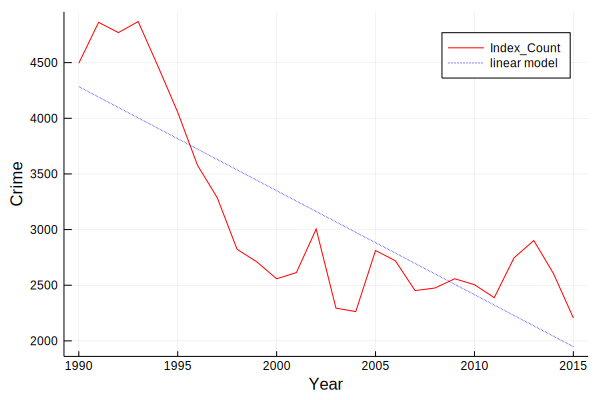

In [26]:
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
xlabel!("Year")
ylabel!("Crime")

# Autoregressive models

In [27]:
# how about using the level of crime last year? (called ``lagged outcome'')
X = [tompkins[2:end,:Index_Count] ones(n-1)]
y = tompkins[1:end-1,:Index_Count]
w = X\y

tompkins[!,:pred_ar1] = vcat(X*w, tompkins[end,:pred_linear]);

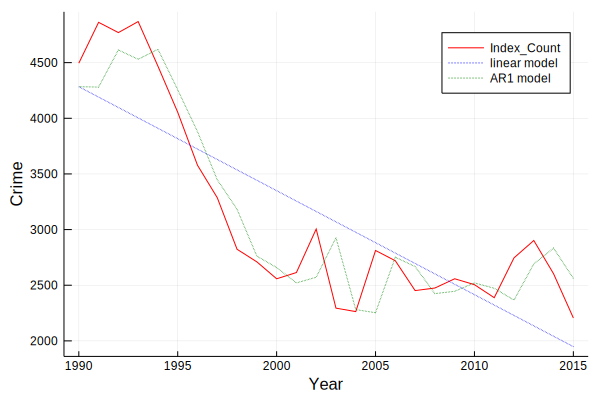

In [28]:
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(tompkins.Year, tompkins.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
xlabel!("Year")
ylabel!("Crime")

In [29]:
# how about using the year *and* the level of crime last year? (called ``lagged outcome'')
X = [tompkins.Year[1:end-1] tompkins.Index_Count[2:end] ones(n-1)]
y = tompkins.Index_Count[1:end-1]
w = X\y

tompkins[!,:pred_ar1_lin] = vcat(X*w, tompkins.pred_linear[end]);

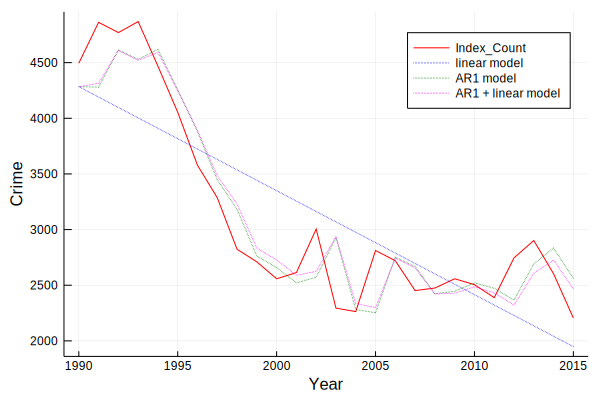

In [30]:
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(tompkins.Year, tompkins.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(tompkins.Year, tompkins.pred_ar1_lin, color=:magenta, linestyle=:dot, label="AR1 + linear model")
xlabel!("Year")
ylabel!("Crime")

# Smoothed models

In [31]:
α = 1
n = length(tompkins.Year)
X = zeros(n,n)
for i=1:n
    for j=1:n
        X[i,j] = exp(-(tompkins.Year[i]-tompkins.Year[j])^2)
    end
end
y = tompkins.Index_Count
w = X\y

tompkins[!,:pred_smooth] = X*w;

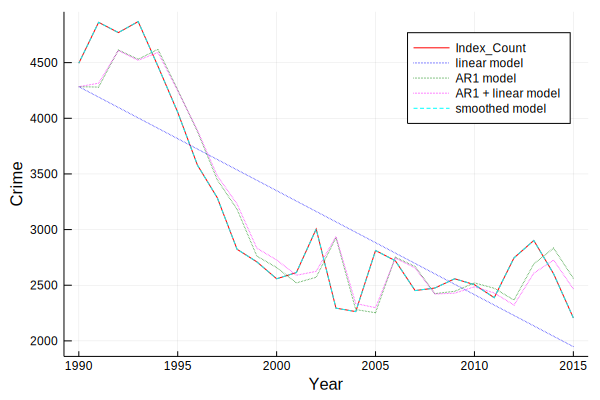

In [32]:
# cyan curve exactly matches red!
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(tompkins.Year, tompkins.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(tompkins.Year, tompkins.pred_ar1_lin, color=:magenta, linestyle=:dot, label="AR1 + linear model")
plot!(tompkins.Year, tompkins.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Year")
ylabel!("Crime")

# Smoothed models

In [33]:
n = length(tompkins.Year)
nknots = Int(round(n/2))
X = zeros(n,nknots)
for i=1:n
    for j=1:nknots
        X[i,j] = exp(-(tompkins.Year[i]-tompkins.Year[2*j])^2)
    end
end
X = [X ones(n)]
y = tompkins.Index_Count
w = X\y

tompkins[!,:pred_smooth] = X*w;

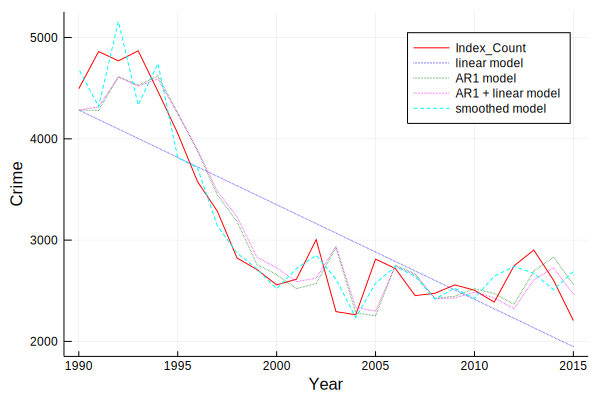

In [34]:
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(tompkins.Year, tompkins.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(tompkins.Year, tompkins.pred_ar1_lin, color=:magenta, linestyle=:dot, label="AR1 + linear model")
plot!(tompkins.Year, tompkins.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed model")
xlabel!("Year")
ylabel!("Crime")

In [15]:
n = length(tompkins.Year)
nknots = Int(round(n/2))
X = zeros(n,nknots)
for i=1:n
    for j=1:nknots
        X[i,j] = exp(-(tompkins.Year[i]-tompkins.Year[2*j])^2)
    end
end
X = [X tompkins.Year ones(n)]
y = tompkins.Index_Count
w = X\y

tompkins[!,:pred_smooth] = X*w;

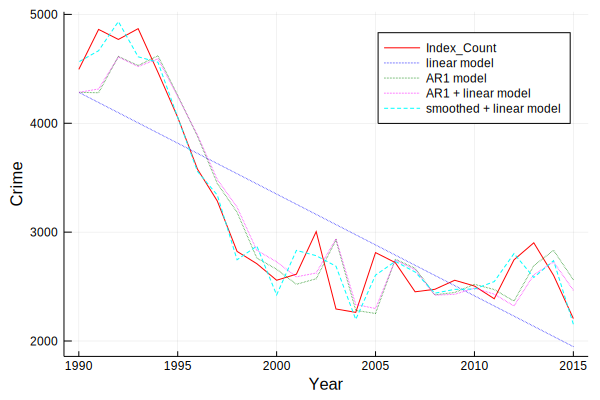

In [16]:
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(tompkins.Year, tompkins.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(tompkins.Year, tompkins.pred_ar1_lin, color=:magenta, linestyle=:dot, label="AR1 + linear model")
plot!(tompkins.Year, tompkins.pred_smooth, color=:cyan, linestyle=:dash, label="smoothed + linear model")
xlabel!("Year")
ylabel!("Crime")

# Regularize + smooth

In [17]:
α = .1
n = length(tompkins.Year)
nknots = Int(n/2)
X = zeros(n,nknots)
for i=1:n
    for j=1:nknots
        X[i,j] = exp(-(tompkins.Year[i]-tompkins.Year[2*j])^2)
    end
end
X = [X tompkins.Year ones(n)]
y = tompkins.Index_Count

# regularize 
n,d = size(X)
id = Diagonal(ones(d))
id[end,end] = 0
id[end-1,end-1] = 0
w = (X'*X + α*id)\X'*y

tompkins[!,:pred_smooth_reg] = X*w;

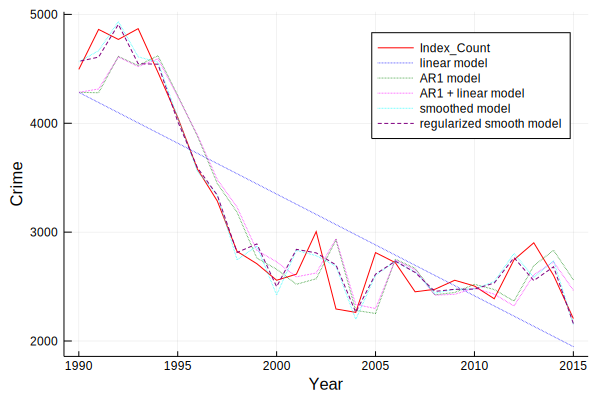

In [18]:
plot(tompkins.Year, tompkins.Index_Count, color=:red, label="Index_Count"),
plot!(tompkins.Year, tompkins.pred_linear, color=:blue, linestyle=:dot, label="linear model")
plot!(tompkins.Year, tompkins.pred_ar1, color=:green, linestyle=:dot, label="AR1 model")
plot!(tompkins.Year, tompkins.pred_ar1_lin, color=:magenta, linestyle=:dot, label="AR1 + linear model")
plot!(tompkins.Year, tompkins.pred_smooth, color=:cyan, linestyle=:dot, label="smoothed model")
plot!(tompkins.Year, tompkins.pred_smooth_reg, color=:purple, linestyle=:dash, label="regularized smooth model")
xlabel!("Year")
ylabel!("Crime")